In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

from mqt.qecc.codes.css_code import CSSCode
from mqt.qecc.codes.rotated_surface_code import RotatedSurfaceCode
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from mqt.qecc.circuit_synthesis import encoding
from mqt.qecc.circuit_synthesis.noise import (
    CircuitLevelNoise,
    CircuitLevelNoiseIdlingParallel,
    CircuitLevelNoiseIdlingSequential,
    ComposedNoiseModel,
)
from mqt.qecc.circuit_synthesis.simulation import (
    NoisyNDFTStatePrepSimulator,
    VerificationNDFTStatePrepSimulator,
    LutDecoder,
)

import stim  
from libs import visualize

import sys, importlib
import mqt.qecc as qecc

print("Python:", sys.version)
print("mqt.qecc version:", getattr(qecc, "__version__", "unknown"))

Python: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.3.19.1)]
mqt.qecc version: 1.9.1.dev158+ga3abd71d0


> Notes:
>- CSSCode is the main CSS/stabilizer code abstraction. It exposes check matrices (Hx, Hz), syndrome helpers, and utilities for logicals.
>- Recent versions include RotatedSurfaceCode(distance=...) as a convenience class for the rotated planar family. 
>- Noise and simulation utilities live under mqt.qecc.circuit_synthesis.noise and .simulation. 

# API overview

## Codes (CSS / stabilizer, surface/rotated)

Construcing a small rotated surface code [[n,k,d]] with distance 3.

In [2]:
surface_code = CSSCode.from_code_name("Surface", distance=3)

Now lets inspect it.

In [3]:
Hx = surface_code.Hx 
Hz = surface_code.Hz 
n = Hx.shape[1] if Hx is not None else Hz.shape[1]
mx, mz = Hx.shape[0], Hz.shape[0]

print("n (data qubits) =", n, "| #X-checks =", mx, "| #Z-checks =", mz)
print("Hx shape:", Hx.shape, "Hz shape:", Hz.shape)

print("X checks (strings) sample:", surface_code.x_checks_as_pauli_strings()[:2])
print("Z checks (strings) sample:", surface_code.z_checks_as_pauli_strings()[:2])

n (data qubits) = 9 | #X-checks = 4 | #Z-checks = 4
Hx shape: (4, 9) Hz shape: (4, 9)
X checks (strings) sample: ['XXIXXIIII', 'IIXIIXIII']
Z checks (strings) sample: ['ZZIIIIIII', 'IZZIZZIII']


> The CSSCode class stores X- and Z-type parity checks as binary matrices Hx and Hz and offers Pauli-string renderings and syndrome utilities.

## Visualization

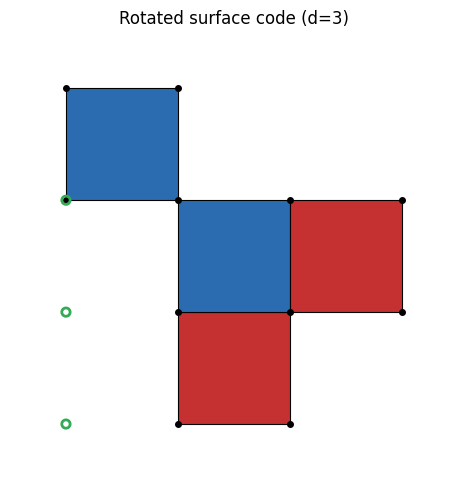

In [4]:
visualize.plot_rotated_surface_from_code(surface_code, logical="Z")

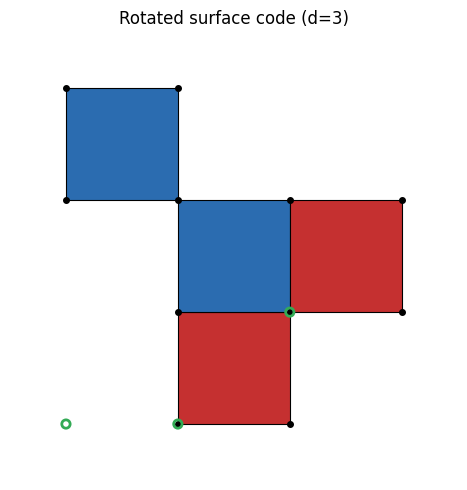

In [5]:
visualize.plot_rotated_surface_from_code(surface_code, logical="X")

## Logical Operators

In [6]:
Lx_strings = surface_code.x_logicals_as_pauli_strings()
Lz_strings = surface_code.z_logicals_as_pauli_strings()
print("Logical X strings:", Lx_strings)
print("Logical Z strings:", Lz_strings)

Logical X strings: ['XXIIIXIII']
Logical Z strings: ['ZIIZIIZII']


For CSS codes, one can obtain logicals via nullspaces modulo stabilizer row-spans. QECC exposes logical checks as strings; here we parse them back to binary X/Z supports.


In [7]:
def pauli_string_to_binary_vectors(pauli_str, n=7):
    x = np.zeros(n, dtype=np.int8)
    z = np.zeros(n, dtype=np.int8)
    for i, p in enumerate(pauli_str):
        if p in ("X", "Y"):
            x[i] = 1
        if p in ("Z", "Y"):
            z[i] = 1
    return x, z

Lx_bin = [pauli_string_to_binary_vectors(s)[0] for s in Lx_strings]
Lz_bin = [pauli_string_to_binary_vectors(s)[1] for s in Lz_strings]

print("logical X:", len(Lx_bin), "example support indices:", np.where(Lx_bin[0])[0].tolist())
print("logical Z:", len(Lz_bin), "example support indices:", np.where(Lz_bin[0])[0].tolist())


logical X: 1 example support indices: [0, 1, 5]
logical Z: 1 example support indices: [0, 3, 6]


> For CSS codes, `Hx` detects X-type errors and `Hz` detects Z-type errors; logical operators are Pauli strings that commute with all checks but are not in the stabilizer group.

## Noise Models

Lets look at a simple circuit-level depolarizing model.

In [8]:
nm = CircuitLevelNoise(
    p_tqg=5e-3,   # two-qubit gate depolarizing prob
    p_sqg=1e-3,   # single-qubit gate depolarizing prob
    p_meas=1e-3,  # measurement flip prob (pre-meas depol)
    p_init=1e-3   # init flip prob (post-init depol)
)

Idling-aware variants (parallel vs sequential scheduling semantics).


In [9]:
nm_idle_par = CircuitLevelNoiseIdlingParallel(
    p_tqg=5e-3, p_sqg=1e-3, p_meas=1e-3, p_init=1e-3, p_idle=5e-4
)
nm_idle_seq = CircuitLevelNoiseIdlingSequential(
    p_tqg=5e-3, p_sqg=1e-3, p_meas=1e-3, p_init=1e-3, p_idle=5e-4
)

Compose multiple models (e.g., to layer specialized effects). 

In [10]:
nm_composed = ComposedNoiseModel([nm_idle_par, nm])

> Circuit-level models cover depolarizing noise on init/measurement/single- and two-qubit gates; idling-aware variants add depolarizing noise on idle timesteps. Models apply to `stim.Circuit` objects.

## Syndrome Extraction

In [11]:
shor_code = CSSCode.from_code_name("Shor")

In [12]:
def syndrome_extraction(code):
    Hx, Hz = code.Hx, code.Hz
    n = Hz.shape[1]
    m_z = Hz.shape[0]
    m_x = Hx.shape[0]

    data = QuantumRegister(n, "data") # data qubits
    anc_z = QuantumRegister(m_z, "ancZ") # Z-stabilizer ancillas
    anc_x = QuantumRegister(m_x, "ancX") # X-stabilizer ancillas
    cz = ClassicalRegister(m_z, "cz") # Z-stabilizer measurement bits
    cx = ClassicalRegister(m_x, "cx") # X-stabilizer measurement bits
    qc = QuantumCircuit(data, anc_z, anc_x, cz, cx)

    # --- Z stabilizers: ancilla in |0>, accumulate Z-parity with CNOT(data->anc), measure ancilla in Z
    for r in range(m_z):
        # ancilla starts in |0>
        for q in range(n):
            if Hz[r, q] == 1:
                qc.cx(data[q], anc_z[r])
        qc.measure(anc_z[r], cz[r])

    # --- X stabilizers: measure X-parity without touching data
    # Prepare ancilla in |+> via H, accumulate parity with CNOT(data->anc), rotate back, measure in Z
    for r in range(m_x):
        qc.h(anc_x[r])  # |+>
        for q in range(n):
            if Hx[r, q] == 1:
                qc.cx(data[q], anc_x[r])
        qc.h(anc_x[r])
        qc.measure(anc_x[r], cx[r])

    return qc

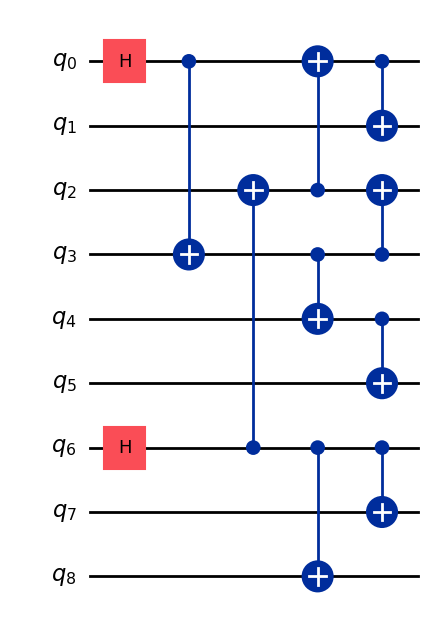

In [13]:
enc = encoding.heuristic_encoding_circuit(shor_code)
enc.draw("mpl")          

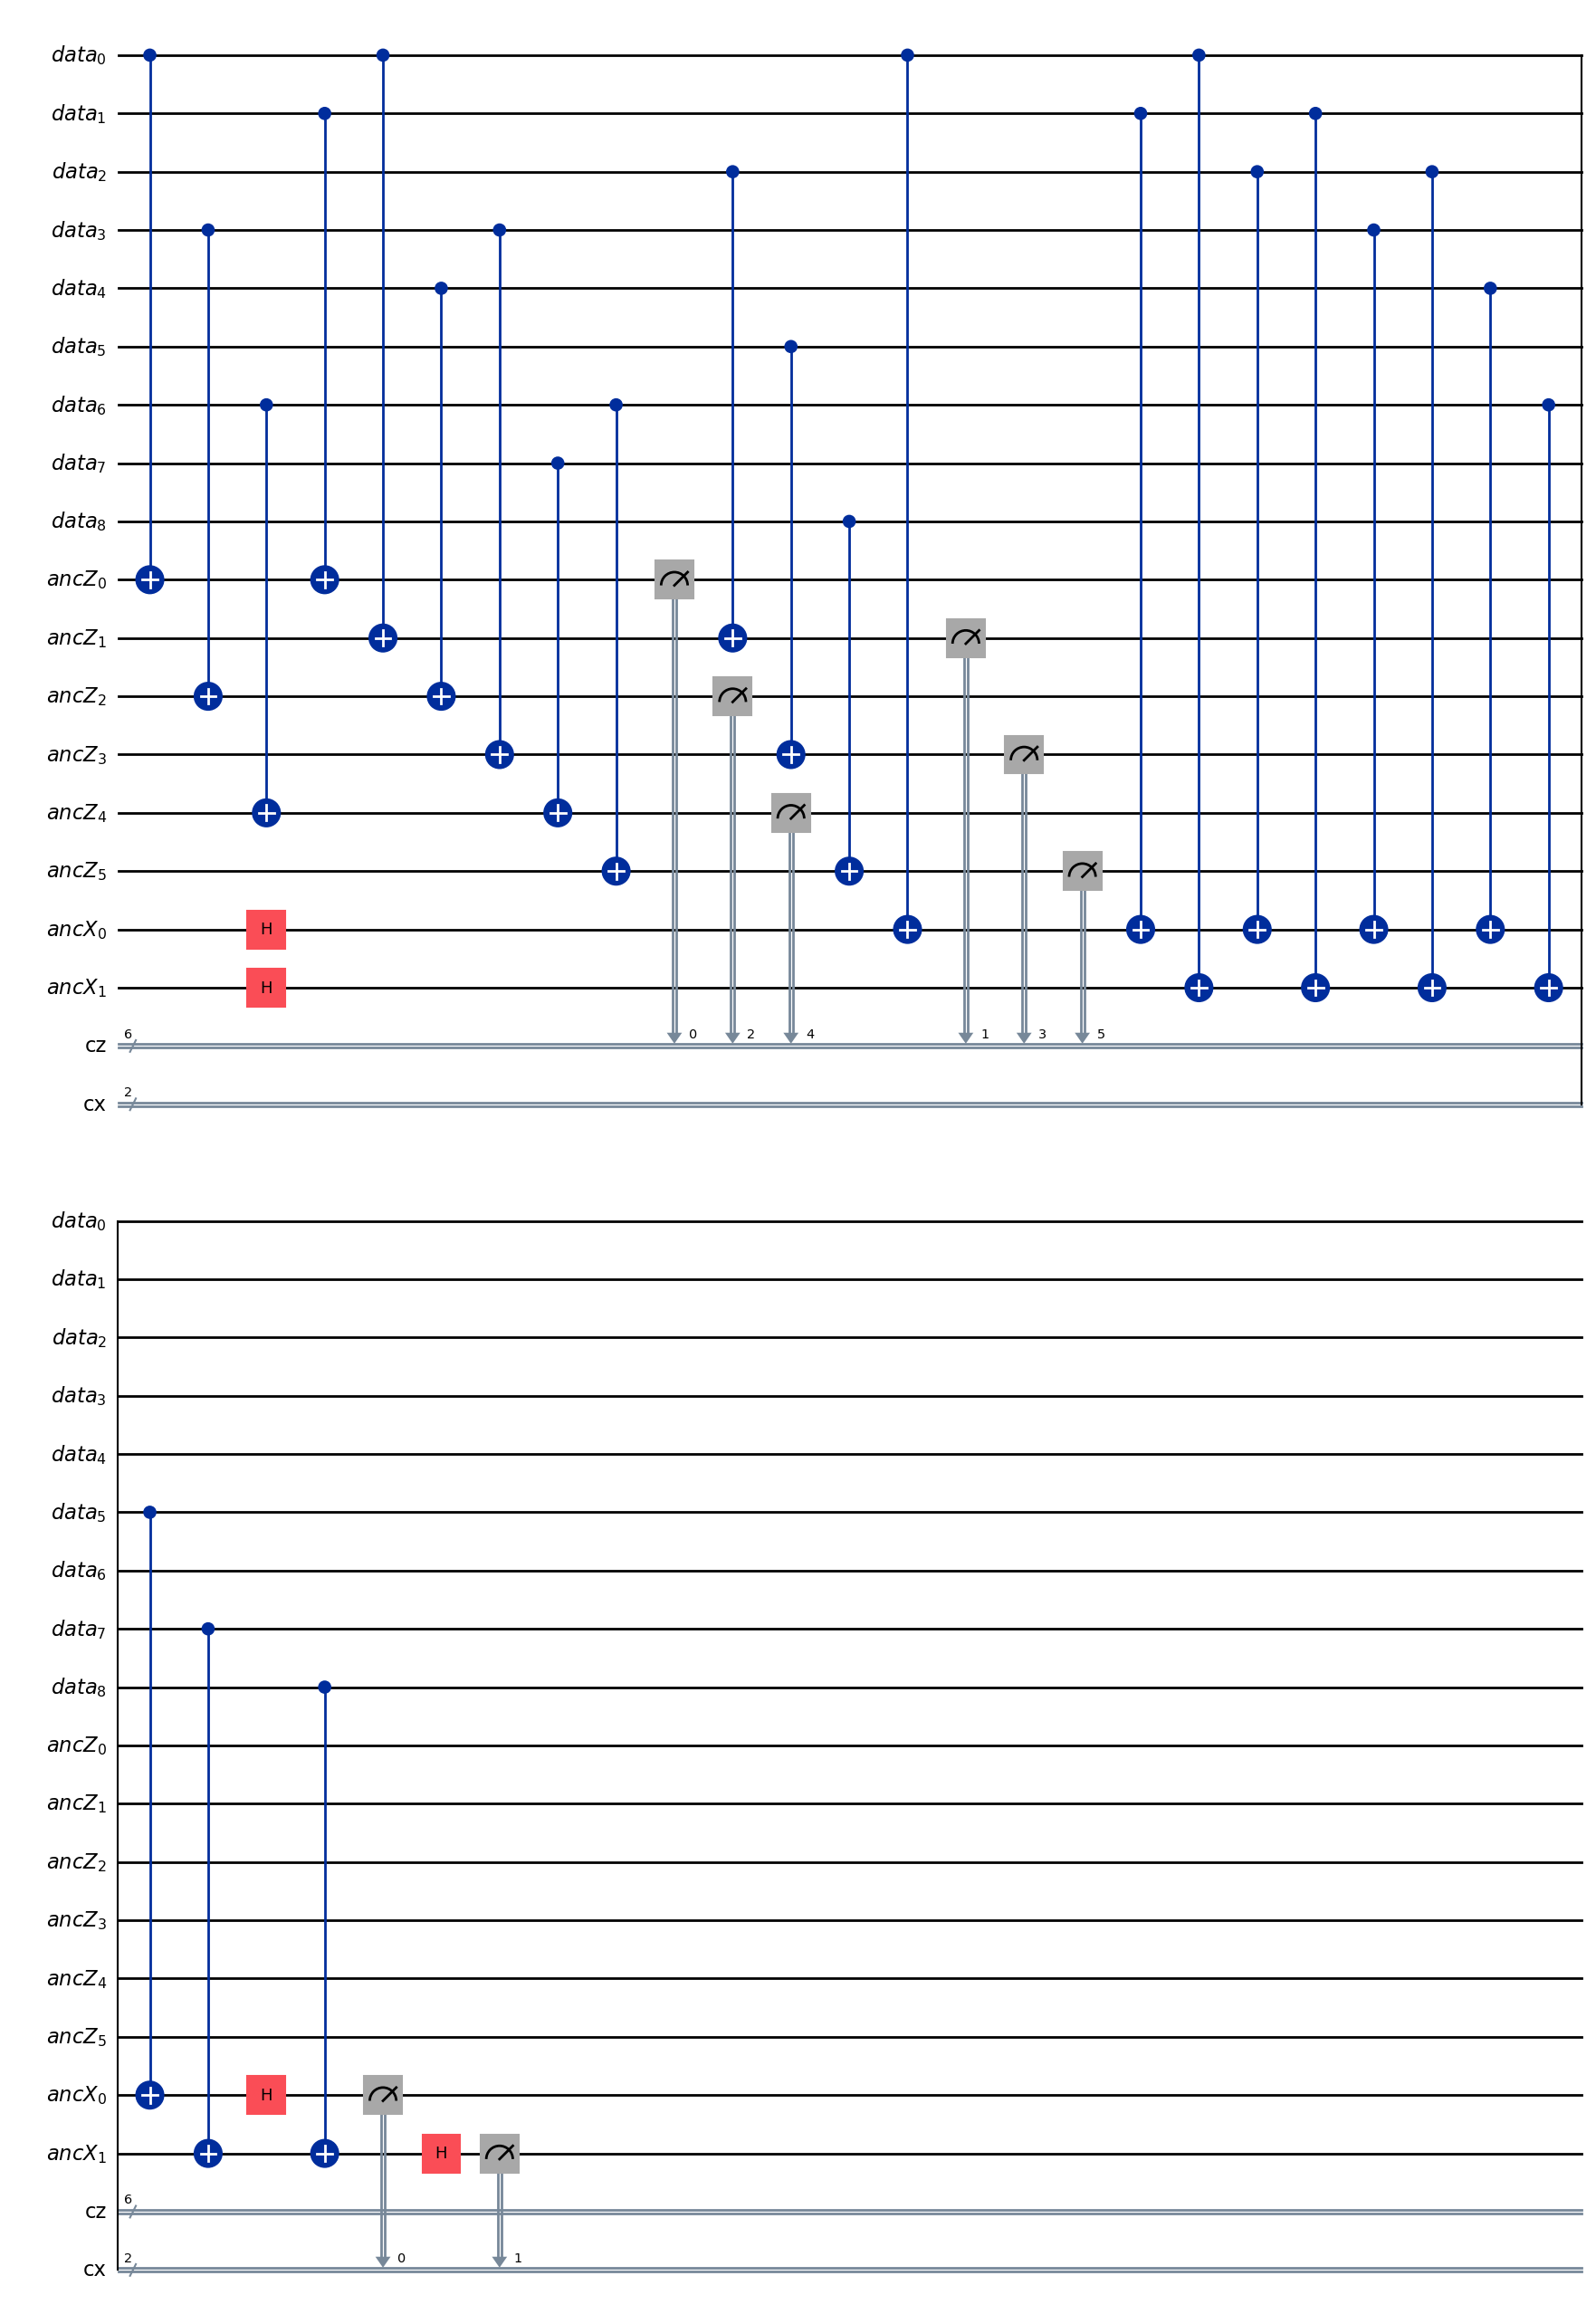

In [14]:
extr = syndrome_extraction(shor_code)
extr.draw("mpl")

## Simulation / Decoding